## Importation des bibliothèques

In [20]:
import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
import keras
from keras.applications import EfficientNetB1
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras_tuner.tuners import RandomSearch
from keras.utils import to_categorical, set_random_seed

from tqdm import tqdm


%matplotlib inline

## Fonctions

In [65]:
# Affiche les courbes de pertes et d'accuracy
def plot_metrics(history):
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Perte du modèle')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Perte')
    ax[0].legend(['Train', 'Validation'])

    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Accuracy du modèle')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(['Train', 'Validation'])

    plt.show()

In [8]:
# Affiche la matrice de confusion du modèle
def conf_mat(y_true, y_pred, cmap='Blues', labels='auto'):
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap=cmap, xticklabels=labels,
                yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [67]:
# Affiche les résultats du modèle (les courbes, la matrice de confusion et le rapport de classification)
def display_results(history, model, x_true, y_true, multiclass=False, labels='auto'):
    plot_metrics(history)
    model.evaluate(x_true, to_categorical(y_true, num_classes=4) if multiclass else y_true)
    y_pred = model.predict(x_true)
    y_pred = np.argmax(y_pred, axis=1)
    print(classification_report(y_true, y_pred))
    conf_mat(y_true, y_pred, labels=labels)

In [16]:
# Pour charger les images à partir d'une liste de chemins
def load_images_from_path(x_paths):
    x = []
    for file_path in tqdm(x_paths):
        image = tf.io.read_file(file_path) # Lecture du fichier
        image = tf.image.decode_png(image, channels = 3) # Décodage du fichier
        image = tf.image.resize(image, size = (240, 240)) # Redimensionnement
        x.append([image])

    return tf.concat(x, axis = 0)

In [22]:
# Fonction pour charger, et redimensionner une image
@tf.function
def preprocess_and_load_image(file_path, resize = (240, 240)):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image, channels = 3)
    image = tf.image.resize(image, resize)

    return image

In [27]:
# Fonction qui retourne un modèle pour Keras Tuner
def build_model_2_classes(hp):
    model = Sequential()
    
    # Chargement des poids efficientNet pré-entrainé sur ImageNet
    efficientNet.load_weights('efficientnetb1_notop.h5')
    
    # Congélation de toutes les couches de l'efficientNet
    for l in efficientNet.layers:
        l.trainable = False
        
    # Décongélation des dernières couches
    hp_unfrozen_layers = hp.Choice('unfrozen_layers', values = [0, 3, 7, 18, 31])
    for l in efficientNet.layers[-hp_unfrozen_layers:]:
        if not isinstance(l, BatchNormalization): # On laisse les couches BatchNormalization gelées
            l.trainable = True

    model.add(efficientNet)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units = hp.Int('units_1', min_value = 512, max_value = 1024, step = 128), activation = 'relu'))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value = 0.1, max_value = 0.5, default = 0.1, step = 0.1)))
    model.add(Dense(units = hp.Int('units_2', min_value = 256, max_value = 512, step = 64), activation = 'relu'))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value = 0.1, max_value = 0.5, default = 0.1, step = 0.1)))
    model.add(Dense(units = 1, activation = 'sigmoid'))

    # hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
    # model.compile(optimizer = tf.optimizers.Adam(learning_rate = hp_learning_rate), loss = 'binary_crossentropy', metrics = ['accuracy'])
    model.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [37]:
# Renvoie un modèle avec les meilleurs hyperparamètres trouvé auparavant avec Keras Tuner
def model_2_classes():
    efficientNet.load_weights('efficientnetb1_notop.h5')
    for l in efficientNet.layers:
        l.trainable = False
    for l in efficientNet.layers[-31:]:
        if not isinstance(l, BatchNormalization):
            l.trainable = True
    x = GlobalAveragePooling2D()(efficientNet.output)
    x = Dense(units = 640, activation = 'relu')(x)
    x = Dropout(rate = 0.3)(x)
    x = Dense(units = 384, activation = 'relu')(x)
    x = Dropout(rate = 0.3)(x)
    outputs = Dense(units = 1, activation = 'sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

In [22]:
def get_img_array(img):
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis = 0)
    return array

In [23]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index = None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [24]:
def return_gradcam(img, heatmap, alpha):

    heatmap = np.uint8(255 * heatmap)

    jet = plt.colormaps.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    return superimposed_img

In [25]:
def grad_cam(img, model, alpha,  last_conv_layer_name):
    img_array = get_img_array(img)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    
    return return_gradcam(img, heatmap, alpha)

In [68]:
# Affiche les images avec les prédictions correctes ou incorrectes ainsi que la heatmap de GradCAM
def display_predictions(y_pred, y_true, x_test, model, labels = labels_2_classes, alpha = 0.4, last_conv_layer_name = 'top_conv', correct = True):
    title = ''
    plt.figure(figsize=(12, 12))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        if correct:
            number = np.random.choice(np.where(y_pred == y_true)[0])
            title = 'Prédictions correctes'
        else:
            number = np.random.choice(np.where(y_pred != y_true)[0])
            title = 'Prédictions incorrectes'
        title += f'\nGradCAM sur la couche {last_conv_layer_name}'
        plt.imshow(grad_cam(x_test[number], model, alpha, last_conv_layer_name))
        plt.axis('off')
        plt.title(f'True : {labels[y_true[number]]}\n Predicted : {labels[y_pred[number]]}')

    plt.suptitle(title, fontsize = 20)
    plt.subplots_adjust(top=0.88)
    plt.show()

In [10]:
set_random_seed(812)
random_state = 42
batch_size = 128
epochs = 50
labels_2_classes = ['Malade', 'Sain']
labels_4_classes = ['Covid', 'Lung Opacity', 'Normal', 'Viral Pneumonia']

# Prétraitement des images

In [11]:
# Chargement des métadonnées
df_covid = pd.read_excel('../data/COVID.metadata.xlsx')
df_lung_opacity = pd.read_excel('../data/Lung_Opacity.metadata.xlsx')
df_viral_pneumonia = pd.read_excel('../data/Viral Pneumonia.metadata.xlsx')
df_normal = pd.read_excel('../data/Normal.metadata.xlsx')

# Par souci de lecture d'image, on remplace ces noms fichier en minuscule
df_normal['FILE NAME'] = df_normal['FILE NAME'].apply(lambda x : x[0] + x[1:].lower())

# Ajout du chemin des images
df_covid['path'] = '../data/COVID/images/' + df_covid['FILE NAME'] + '.png'
df_lung_opacity['path'] = '../data/Lung_Opacity/images/' + df_lung_opacity['FILE NAME'] + '.png'
df_viral_pneumonia['path'] = '../data/Viral_Pneumonia/images/' + df_viral_pneumonia['FILE NAME'] + '.png'
df_normal['path'] = '../data/Normal/images/' + df_normal['FILE NAME'] + '.png'


# Concaténation des données
df = pd.concat([df_covid, df_lung_opacity, df_viral_pneumonia, df_normal], axis = 0)

# Ajout du chemin des images avec les masques
df['path_mask'] = df['path'].apply(lambda x : x.replace('images', 'overlay'))

# Ajout d'une colonne label pour 2 et 4 classes
df['label_4_name'] = df['path'].apply(lambda x : x.split('/')[2])
df['label_4'] = df['label_4_name'].replace({'COVID' : 0, 'Lung_Opacity' : 1, 'Normal' : 2, 'Viral_Pneumonia' : 3})

df['label_2'] = df['label_4'].apply(lambda x : 1 if x == 2 else 0)
df['label_2_name'] = df['label_2'].replace({1 : 'Sain', 0 : 'Malade'})

# On enlève les colonnes inutiles
df = df.drop(['FORMAT', 'SIZE', 'URL', 'FILE NAME'], axis = 1)

In [13]:
# Échantillonner aléatoirement 5000 images de chaque classe pour la classification binaire
df5000 = df.groupby('label_2').apply(lambda x: x.sample(n = 5000, random_state = random_state)).reset_index(drop = True)
df5000 = df5000.drop(['label_4_name', 'label_4'], axis = 1)

# Échantillonner aléatoirement 1250 images de chaque classe pour la classification multiclasses
df1000 = df.groupby('label_4').apply(lambda x: x.sample(n = 1250, random_state = random_state)).reset_index(drop = True)
df1000 = df1000.drop(['label_2_name', 'label_2'], axis = 1)

## Séparartion en train/test

In [15]:
# Séparation des données en train/test
X_train_path, X_test_path, y_train, y_test = train_test_split(df5000['path'],
                                                              df5000['label_2'],
                                                              test_size = 0.2,
                                                              random_state = random_state)

# Spération des données en train/validation
X_train_path, X_validation_path, y_train, y_validation = train_test_split(X_train_path,
                                                                          y_train,
                                                                          test_size = 0.1,
                                                                          random_state = random_state)

## Chargement du jeu de données

### Chargement en mémoire des données de test

In [17]:
X_test = load_images_from_path(X_test_path)
X_validation = load_images_from_path(X_validation_path)

100%|██████████| 800/800 [00:02<00:00, 296.22it/s]


#### Vérification du chargement

In [21]:
print(f"Image X_test #0 - Dimension: {X_test[0].shape}")
print(f"Image X_validation #0 - Dimension: {X_validation[0].shape}")

Image X_test #0 - Dimension: (240, 240, 3)
Image X_validation #0 - Dimension: (240, 240, 3)


### Définition d'un dataset permettant de charger les images à chaque itération du modèle

In [23]:
# Définition d'un dataset
dataset_train = tf.data.Dataset.from_tensor_slices((X_train_path, y_train))
dataset_train = dataset_train.map(lambda x, y: (preprocess_and_load_image(x), y), num_parallel_calls = -1)
dataset_train = dataset_train.batch(batch_size)

#### Vérification du chargement

In [24]:
for batch in dataset_train.take(1):
    images, _ = batch
    print(f"Image Train Dataset #0 - Dimension: {images[0].shape}")

print(f"Nombre total d'images dans le dataset : {len(X_train_path)}")
print(f"Nombre total d'images dans le dataset : {dataset_train.cardinality() * batch_size} (pas égal car le nombre d'images n'est pas un multiple du batch_size ({batch_size})")

Image Train Dataset #0 - Dimension: (240, 240, 3)
Nombre total d'images dans le dataset : 7200
Nombre total d'images dans le dataset : 7296 (pas égal car le nombre d'images n'est pas un multiple du batch_size (128)


### Callbacks

In [47]:
# Arrête l'apprentissage quand la val_loss ne s'améliore plus
early_stopping = EarlyStopping(monitor = 'val_loss',
                                         patience = 5,
                                         restore_best_weights = True)

### Instanciation du modèle EfficientNetB1

In [39]:
inputs = keras.Input(shape=(240, 240, 3))
efficientNet = EfficientNetB1(input_tensor = inputs, weights = 'imagenet', include_top = False, input_shape = (240, 240, 3))

# On gèle toutes les couches
for layer in efficientNet.layers:
    layer.trainable = False

## Tuning d'hyperparamètres

In [28]:
tuner = RandomSearch(build_model_2_classes, objective = 'val_loss', max_trials = 50, project_name="2_classes_sans_masques")

In [29]:
tuner.search(dataset_train, epochs = 5, validation_data = (X_validation, y_validation))

Trial 50 Complete [00h 01m 44s]
val_loss: 0.20628634095191956

Best val_loss So Far: 0.19012513756752014
Total elapsed time: 01h 11m 48s
INFO:tensorflow:Oracle triggered exit


In [30]:
tuner.results_summary()

Results summary
Results in .\2_classes_sans_masques
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 29 summary
Hyperparameters:
unfrozen_layers: 31
units_1: 640
dropout_1: 0.30000000000000004
units_2: 384
dropout_2: 0.30000000000000004
Score: 0.19012513756752014

Trial 47 summary
Hyperparameters:
unfrozen_layers: 31
units_1: 640
dropout_1: 0.2
units_2: 256
dropout_2: 0.5
Score: 0.19064192473888397

Trial 05 summary
Hyperparameters:
unfrozen_layers: 31
units_1: 896
dropout_1: 0.4
units_2: 512
dropout_2: 0.30000000000000004
Score: 0.19109010696411133

Trial 35 summary
Hyperparameters:
unfrozen_layers: 18
units_1: 640
dropout_1: 0.30000000000000004
units_2: 448
dropout_2: 0.30000000000000004
Score: 0.19214162230491638

Trial 36 summary
Hyperparameters:
unfrozen_layers: 31
units_1: 896
dropout_1: 0.4
units_2: 384
dropout_2: 0.30000000000000004
Score: 0.1938018798828125

Trial 40 summary
Hyperparameters:
unfrozen_layers: 18
units_1: 640
dropout_1: 0.4
units_2: 320


# Entrainement

## Modèle de classification binaire

In [32]:
model = model_2_classes()

In [11]:
history = model.fit(dataset_train, epochs = epochs, validation_data = (X_validation, y_validation), callbacks = [early_stopping])

Epoch 1/50
57/57 [==============================] - 31s 309ms/step - loss: 0.4414 - accuracy: 0.7981 - val_loss: 0.2852 - val_accuracy: 0.8900
Epoch 2/50
57/57 [==============================] - 15s 271ms/step - loss: 0.2940 - accuracy: 0.8764 - val_loss: 0.2346 - val_accuracy: 0.9112
Epoch 3/50
57/57 [==============================] - 15s 269ms/step - loss: 0.2512 - accuracy: 0.8950 - val_loss: 0.2141 - val_accuracy: 0.9175
Epoch 4/50
57/57 [==============================] - 15s 267ms/step - loss: 0.2152 - accuracy: 0.9158 - val_loss: 0.2090 - val_accuracy: 0.9200
Epoch 5/50
57/57 [==============================] - 15s 267ms/step - loss: 0.1978 - accuracy: 0.9237 - val_loss: 0.2137 - val_accuracy: 0.9187
Epoch 6/50
57/57 [==============================] - 15s 266ms/step - loss: 0.1753 - accuracy: 0.9335 - val_loss: 0.1999 - val_accuracy: 0.9262
Epoch 7/50
57/57 [==============================] - 15s 265ms/step - loss: 0.1639 - accuracy: 0.9372 - val_loss: 0.2108 - val_accuracy: 0.9200

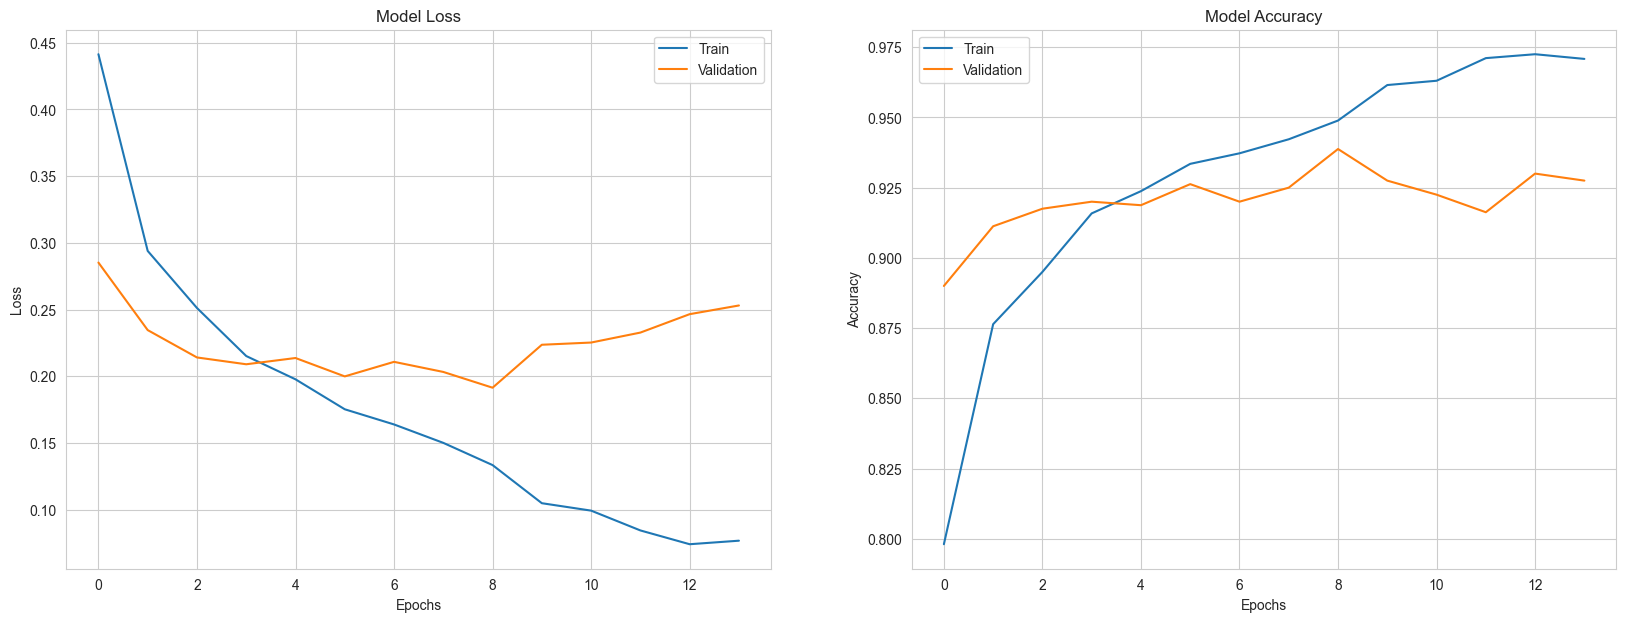

63/63 [==============================] - 6s 64ms/step
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      1012
           1       0.92      0.95      0.94       988

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000


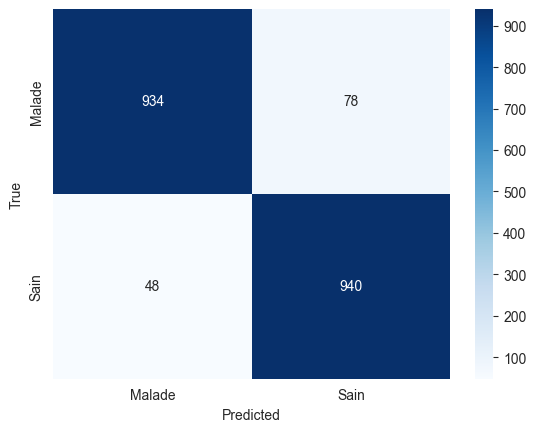

In [12]:
display_results(history, model, X_test, y_test, labels = labels_2_classes)

In [32]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)

63/63 [==============================] - 5s 72ms/step


## GradCAM

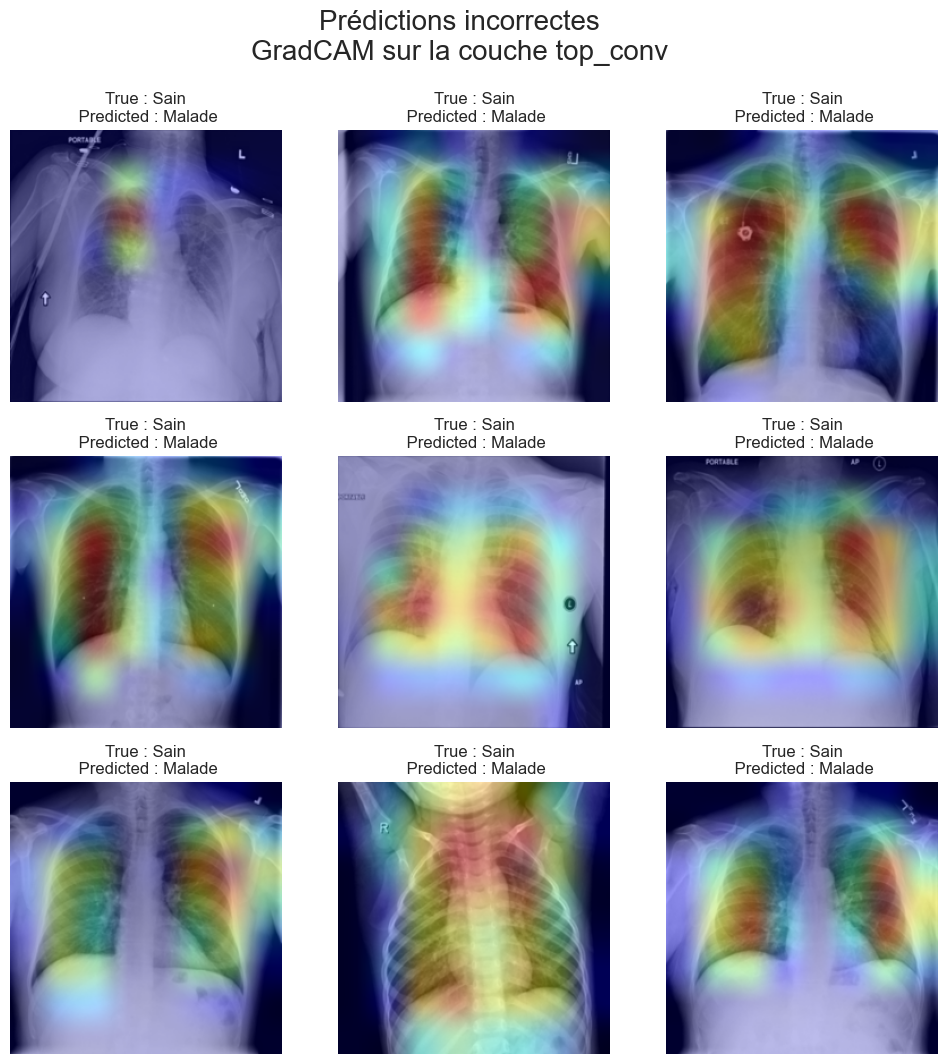

In [69]:
display_predictions(y_pred, y_test, X_test, model, alpha = 0.5, correct = False)

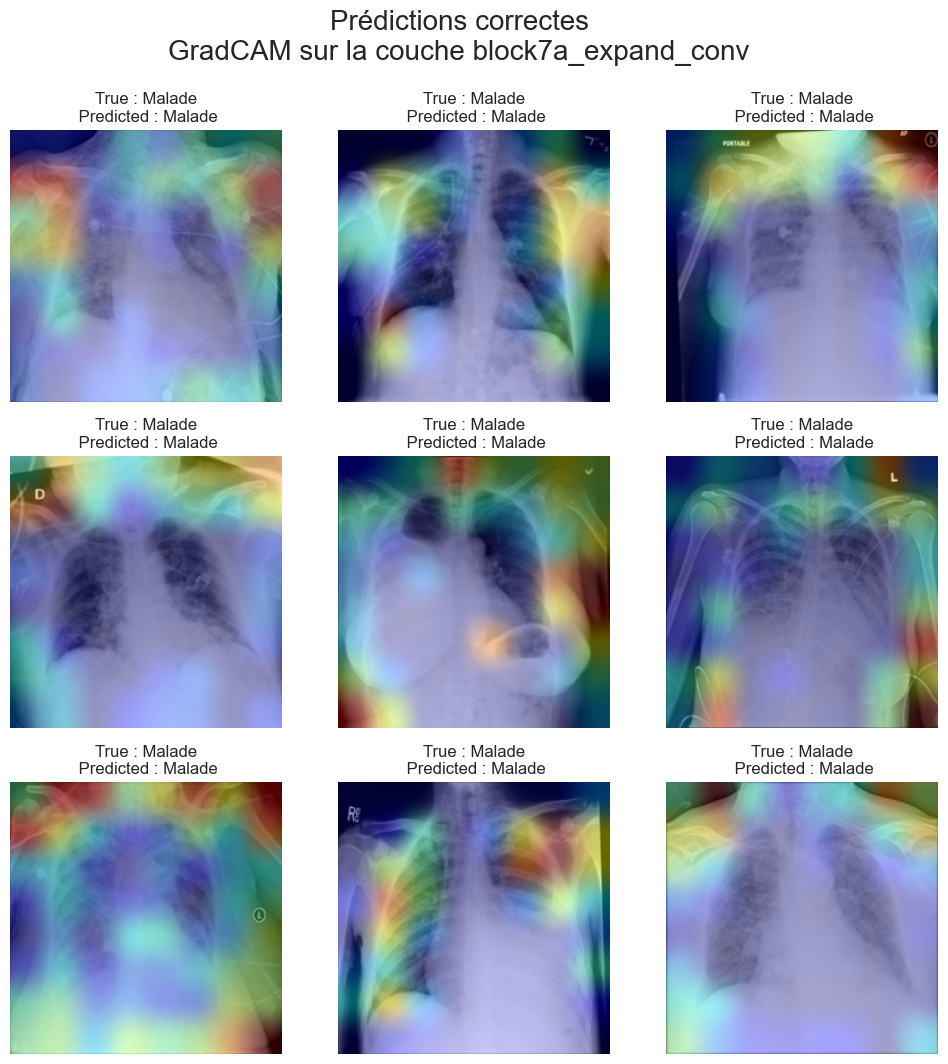

In [63]:
display_predictions(y_pred, y_test, X_test, model, alpha = 0.5, last_conv_layer_name = 'block7a_expand_conv', correct = True)